# MODEL FRUIT METABOLISM

### Import model

##### Warning: 

- CPLEX cannot be provided on binder because of licensing issues. In the absence of CPLEX, the script will rely on GLPK to solve the model. FVA runs can hence take very long time. If interested in running FVA, we recommend that you download the scripts, download jupyter notebook, install required python libraries (see requirements.txt for list of libraries required) and run the analysis offline.

In [1]:
from cobra import io, flux_analysis, util
from cobra.core import Metabolite, Reaction
import numpy as np
from studyFunctions import *
%matplotlib inline

In [2]:
cobra_model2 = io.sbml.create_cobra_model_from_sbml_file("Models/ConstrainedFruitModel.xml")
if "cplex" in util.solvers.keys():
    cobra_model2.solver = "cplex"
else:
    cobra_model2.solver = "glpk"
    
List2edit = list()
for met in cobra_model2.metabolites:
    if met.id.endswith("_None"):
        List2edit.append(met)

for met in List2edit:
    met.id = met.id.replace("_None","")

cobra_model2.metabolites._generate_index()

weightings = dict()
for rxn in cobra_model2.reactions:
    weightings[rxn.id]=1

for k in ['ILE', '4_AMINO_BUTYRATE', 'GLN', 'GLC', 'GLY', 'CIT', 'GLT', 'FUM', 'SER', 'LYS', 'PRO', 'L_ASPARTATE',
          'ASN', 'L_ALPHA_ALANINE', 'VAL', 'STARCH', 'THR', 'SUCROSE', 'FRU', 'TRP', 'PHE', 'MET', 'MAL', 'TYR']:
    for i in range(1,10):
        if k != "STARCH":
            weightings[k+"_signal"+str(i)]=0

solution2 = pfba_Weighted(cobra_model2,weightings)

# Validating the fruit model's metabolic content

In [3]:
from studyFunctions import generateBoundsFromBiomass


#Day time points of interest
DPA = list(np.linspace(8,59,11))
for i in range(0,len(DPA)):
    DPA[i]=round(DPA[i],1)

mets = ("GLC","FRU","SUC","MAL","CIT","L_ALPHA_ALANINE","ASN","L_ASPARTATE","GABA","GLT",
        "GLN","GLY","ILE","LYS","MET","PHE","PRO","SER","THR","TRP","TYR","VAL","Pi","FUM")
dfile="Data/Data_OrganicSolutes.csv"
Nsampl= 1000
Ssampl= 0.80

Conc = dict()
Conc_max = dict()
Conc_min = dict()
flux_max = dict()
flux_min = dict()

for met in mets:
  print "Processing "+met+"..."
  [Conc[met],Conc_max[met],Conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,
                                                                                                met=met,
                                                                                                Nsampling=Nsampl,
                                                                                                DPA=DPA,
                                                                                                show_plots=False,
                                                                                                degree=3,
                                                                                                Ssampling=Ssampl,
                                                                                                start=8,stop=59)

mets = ("STARCH",)
dfile="Data/Data_Starch_Protein.csv"

for met in mets:
  print "Processing "+met+"..."
  [Conc[met],Conc_max[met],Conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,
                                                                                                met=met,
                                                                                                Nsampling=Nsampl,
                                                                                                DPA=DPA,
                                                                                                show_plots=False,
                                                                                                degree=3,
                                                                                                Ssampling=Ssampl,
                                                                                                start=8,stop=59)


Processing GLC...
Processing FRU...
Processing SUC...
Processing MAL...
Processing CIT...
Processing L_ALPHA_ALANINE...
Processing ASN...
Processing L_ASPARTATE...
Processing GABA...
Processing GLT...
Processing GLN...
Processing GLY...
Processing ILE...
Processing LYS...
Processing MET...
Processing PHE...
Processing PRO...
Processing SER...
Processing THR...
Processing TRP...
Processing TYR...
Processing VAL...
Processing Pi...
Processing FUM...
Processing STARCH...


In [4]:
Conc["SUCROSE"]=Conc["SUC"]
del Conc["SUC"]
del Conc["Pi"]

In [5]:
Conc["4_AMINO_BUTYRATE"]=Conc["GABA"]
del Conc["GABA"]

In [6]:
Conc_max["SUCROSE"]=Conc_max["SUC"]
del Conc_max["SUC"]
del Conc_max["Pi"]
Conc_max["4_AMINO_BUTYRATE"]=Conc_max["GABA"]
del Conc_max["GABA"]

In [7]:
Conc_min["SUCROSE"]=Conc_min["SUC"]
del Conc_min["SUC"]
del Conc_min["Pi"]
Conc_min["4_AMINO_BUTYRATE"]=Conc_min["GABA"]
del Conc_min["GABA"]

In [8]:
from studyFunctions import FBA_FVA_run
cobra_model5 = FBA_FVA_run(cobra_model2,cobra_model2.reactions.get_by_id("Final_Biomass_tx"),
                           rxnlist = cobra_model2.reactions.query("_signal")+ \
                           cobra_model2.reactions.query("STARCH_p_Transfer"),
                           weightings=weightings)

Runing pFBA
Setting SOF model
1.1026173081545578
Running FVA
Processing results


    Processing results...

In [9]:

xlist = list()
for i in range(1,11):
    i=i*20
    xlist.append(i)
barwidth = 6
xlist2 = list()
for i in range(1,11):
    i=i*20
    xlist2.append(round(i-barwidth,2))

metdict = dict()
maxdict = dict()
mindict = dict()
for met in Conc.keys():
    templist = list()
    maxlist=list()
    minlist=list()
    for i in range(1,10):
        if met != "STARCH":
            templist.append(solution2.fluxes.get(met+"_c_Transfer"+str(i)+str(i+1))+solution2.fluxes.get(met+"_v_Transfer"+str(i)+str(i+1)))
            maxlist.append(cobra_model5.fva["maximum"][met+"_signal"+str(i)])
            minlist.append(cobra_model5.fva["minimum"][met+"_signal"+str(i)])
        else:
            templist.append(solution2.fluxes.get(met+"_p_Transfer"+str(i)+str(i+1)))
            maxlist.append(cobra_model5.fva["maximum"][met+"_p_Transfer"+str(i)+str(i+1)])
            minlist.append(cobra_model5.fva["minimum"][met+"_p_Transfer"+str(i)+str(i+1)])
    if met != "STARCH":
        templist.append(abs(solution2.fluxes.get("Final_Biomass_tx")*cobra_model2.reactions.get_by_id("Final_Biomass_tx").metabolites.get(cobra_model2.metabolites.get_by_id(met+"_b10"))))
        maxlist.append(0)
        minlist.append(0)
    metdict[met]=templist
    maxdict[met]=maxlist
    mindict[met]=minlist



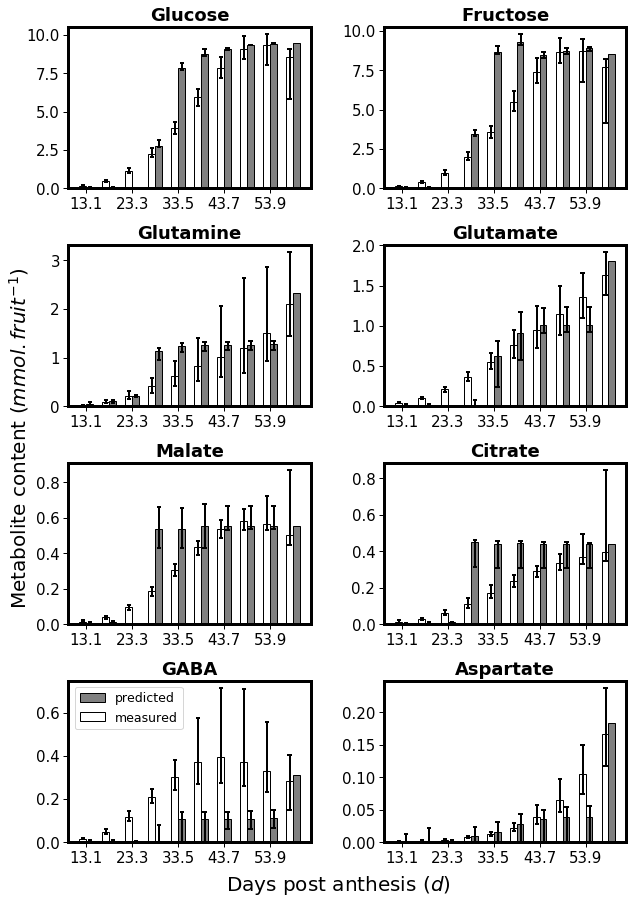

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,15))
titledict = {"GLC":"Glucose","FRU":"Fructose",
             "MAL":"Malate","CIT":"Citrate",
             "GLN":"Glutamine","GLT":"Glutamate",
             "4_AMINO_BUTYRATE":"GABA","L_ASPARTATE":"Aspartate"}
import string
alphabets = list(string.ascii_lowercase)

i=0
for met in ["GLC","FRU","GLN","GLT","MAL","CIT","4_AMINO_BUTYRATE","L_ASPARTATE"]:
    row = int(round(i/2))
    col = int(round(i%2))
    
    ax = axes[row,col]
    if met=="STARCH":
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",zorder=-1,label="predicted")
    else:
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",edgecolor="black",zorder=-1,label="predicted")
    
    offset2 = 0
    if col == 1:
        offset2 = 1
    for k in range(0,len(xlist)):
        ax.plot([xlist[k]+offset2,xlist[k]+offset2],[maxdict[met][k],mindict[met][k]],color="black",linewidth=2)
        ax.plot([xlist[k]+(float(offset2)/2)-1,xlist[k]+(float(offset2)/2)+1],[mindict[met][k],mindict[met][k]],color="black",linewidth=2)
        ax.plot([xlist[k]+(float(offset2)/2)-1,xlist[k]+(float(offset2)/2)+1],[maxdict[met][k],maxdict[met][k]],color="black",linewidth=2)
    ax.bar(xlist2,Conc[met][1:],width=barwidth,color="white",edgecolor="black",zorder=1,label="measured")
    for k in range(0,len(xlist2)):
        ax.plot([xlist2[k]+offset2,xlist2[k]+offset2],[Conc_max[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_max[met][1:][k],Conc_max[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_min[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
    ax.set_title(titledict[met],fontweight="bold")
    offset = float(barwidth)/2
    ax.set_xticks([round(xlist[0]-offset,2),round(xlist[2]-offset,2),round(xlist[4]-offset,2),round(xlist[6]-offset,2),round(xlist[8]-offset,2)])
    ax.set_xticklabels([round(DPA[1],1),round(DPA[3],1),round(DPA[5],1),round(DPA[7],1),round(DPA[9],1)])
    
    if met == "4_AMINO_BUTYRATE":
        ax.legend(loc="upper left",fontsize = 12.5)
    
    i=i+1
for j in range(i,8):
    row = int(round(j/2))
    col = int(round(j%2))
    ax = axes[row,col]
    ax.set_visible(False)
plt.subplots_adjust(wspace = 0.3,hspace=0.35)
fig.text(0.5, 0.08, 'Days post anthesis ($d$)', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Metabolite content ($mmol.fruit^{-1}$)', va='center', rotation='vertical', fontsize=20)
plt.savefig("Figure6.png")


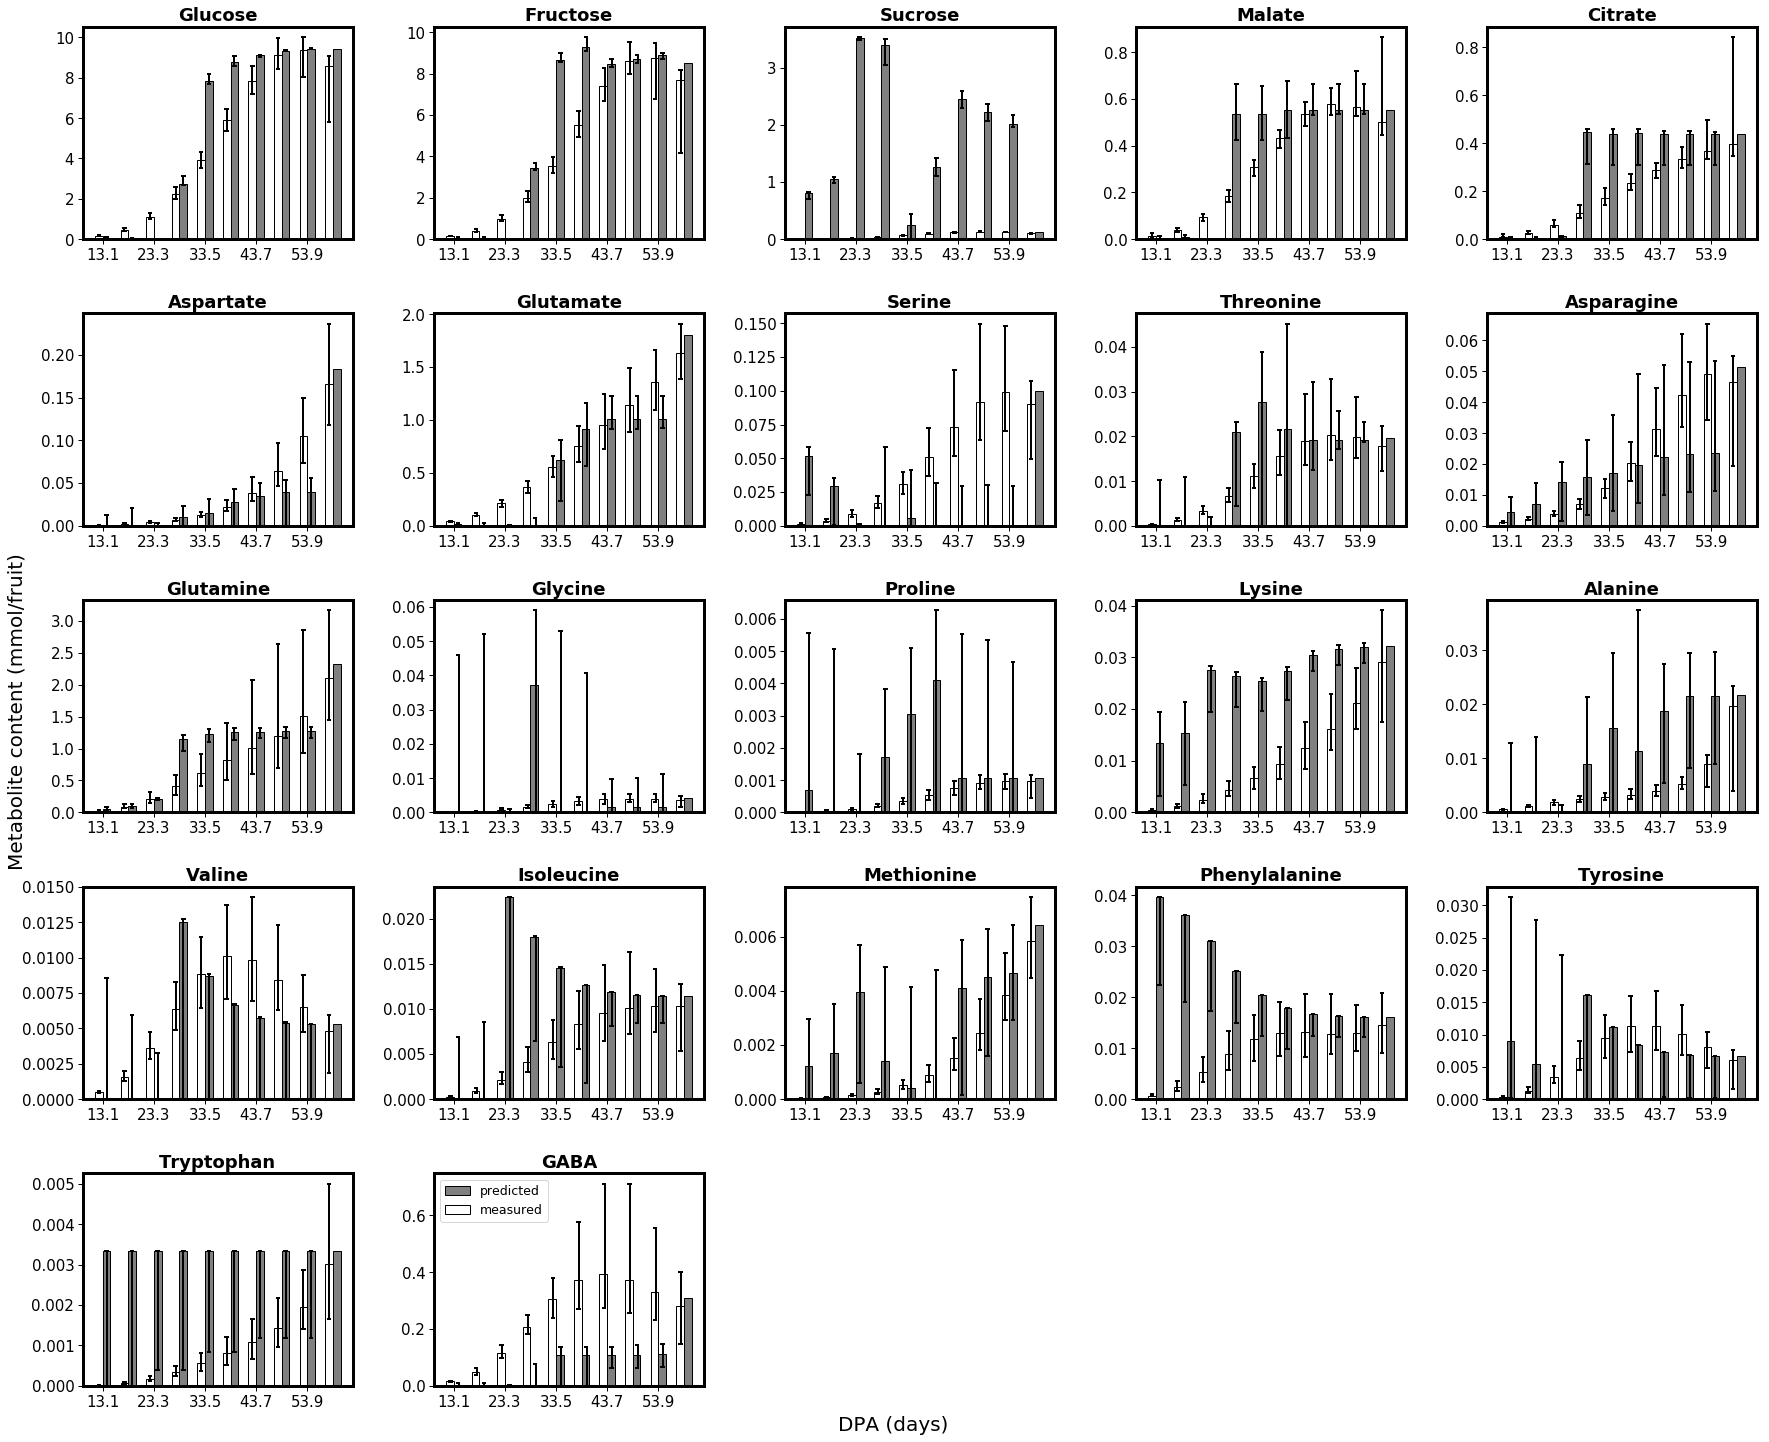

In [11]:
xlist3 = list()
for x in xlist:
    xlist3.append(x-7)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(30,25))
titledict = {"GLC":"Glucose","FRU":"Fructose","SUCROSE":"Sucrose","MAL":"Malate",
             "CIT":"Citrate","GLN":"Glutamine","GLT":"Glutamate","4_AMINO_BUTYRATE":"GABA",
             "L_ASPARTATE":"Aspartate","SER":"Serine","THR":"Threonine","ASN":"Asparagine",
             "GLY":"Glycine","PRO":"Proline","LYS":"Lysine","L_ALPHA_ALANINE":"Alanine",
             "VAL":"Valine","ILE":"Isoleucine","MET":"Methionine","PHE":"Phenylalanine",
             "TYR":"Tyrosine","TRP":"Tryptophan"}
import string
alphabets = list(string.ascii_lowercase)

i=0
for met in ["GLC","FRU","SUCROSE","MAL","CIT","L_ASPARTATE","GLT","SER","THR","ASN","GLN",
            "GLY","PRO","LYS","L_ALPHA_ALANINE","VAL","ILE","MET","PHE","TYR","TRP","4_AMINO_BUTYRATE"]:
    row = int(round(i/5))
    col = int(round(i%5))
    
    ax = axes[row,col]
    if met=="STARCH":
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",zorder=-1,label="predicted")
    else:
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",edgecolor="black",zorder=-1,label="predicted")
    
    offset2 = 0
    if col == 1:
        offset2 = 1
    for k in range(0,len(xlist)):
        ax.plot([xlist[k]+offset2,xlist[k]+offset2],[maxdict[met][k],mindict[met][k]],color="black",linewidth=2)
        ax.plot([xlist[k]+(float(offset2)/2)-1,xlist[k]+(float(offset2)/2)+1],[mindict[met][k],mindict[met][k]],color="black",linewidth=2)
        ax.plot([xlist[k]+(float(offset2)/2)-1,xlist[k]+(float(offset2)/2)+1],[maxdict[met][k],maxdict[met][k]],color="black",linewidth=2)
    ax.bar(xlist2,Conc[met][1:],width=barwidth,color="white",edgecolor="black",zorder=1,label="measured")
    for k in range(0,len(xlist2)):
        ax.plot([xlist2[k]+offset2,xlist2[k]+offset2],[Conc_max[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_max[met][1:][k],Conc_max[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_min[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
    ax.set_title(titledict[met],fontweight="bold")
    offset = float(barwidth)/2
    ax.set_xticks([round(xlist[0]-offset,2),round(xlist[2]-offset,2),round(xlist[4]-offset,2),round(xlist[6]-offset,2),round(xlist[8]-offset,2)])
    ax.set_xticklabels([round(DPA[1],1),round(DPA[3],1),round(DPA[5],1),round(DPA[7],1),round(DPA[9],1)])
    
    if met == "4_AMINO_BUTYRATE":
        ax.legend(loc="upper left",fontsize = 12.5)
    
    i=i+1
for j in range(i,25):
    row = int(round(j/5))
    col = int(round(j%5))
    ax = axes[row,col]
    ax.set_visible(False)
plt.subplots_adjust(wspace = 0.3,hspace=0.35)
fig.text(0.5, 0.1, 'DPA (days)', ha='center', fontsize=20)
fig.text(0.09, 0.5, 'Metabolite content (mmol/fruit)', va='center', rotation='vertical', fontsize=20)
plt.savefig("FigureS1.svg",format="svg")
plt.legend()
plt.show()

#### Plot sucrose, starch in default, no phloem and no starch accumulation

In [12]:


rxnlist= list()
for i in range(2,11):
    for met in ["STARCH_p_Transfer"]:
        rxnlist.append(cobra_model2.reactions.get_by_id(met+str(i-1)+str(i)))
for i in range(1,10):
    for rxn in ["Phloem_uptake_tx","SUCROSE_signal","GLC_signal","FRU_signal"]:
        rxnlist.append(cobra_model2.reactions.get_by_id(rxn+str(i)))

        

cobra_model3 = cobra_model2.copy()

for i in range(1,11):
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000

temp_solution = pfba_Weighted(cobra_model3,weightings)       


rxnlist2= list()
for i in range(2,11):
    for met in ["STARCH_p_Transfer"]:
        rxnlist2.append(cobra_model3.reactions.get_by_id(met+str(i-1)+str(i)))
for i in range(1,10):
    for rxn in ["Phloem_uptake_tx","SUCROSE_signal","GLC_signal","FRU_signal"]:
        rxnlist2.append(cobra_model3.reactions.get_by_id(rxn+str(i)))
        

cobra_model4 = cobra_model2.copy()

for i in range(1,10):
    cobra_model4.reactions.get_by_id("STARCH_p_Transfer"+str(i)+str(i+1)).lower_bound = 0
    cobra_model4.reactions.get_by_id("STARCH_p_Transfer"+str(i)+str(i+1)).upper_bound = 0

temp_solution2 = pfba_Weighted(cobra_model4,weightings)       


rxnlist3= list()
for i in range(2,11):
    for met in ["STARCH_p_Transfer"]:
        rxnlist3.append(cobra_model4.reactions.get_by_id(met+str(i-1)+str(i)))
for i in range(1,10):
    for rxn in ["Phloem_uptake_tx","SUCROSE_signal","GLC_signal","FRU_signal"]:
        rxnlist3.append(cobra_model4.reactions.get_by_id(rxn+str(i)))        

        
import time
print(time.ctime())
cobra_model6 = FBA_FVA_run(cobra_model2,cobra_model2.reactions.get_by_id("Final_Biomass_tx"),rxnlist = rxnlist, weightings=weightings)
cobra_model7 = FBA_FVA_run(cobra_model3,cobra_model3.reactions.get_by_id("Final_Biomass_tx"),rxnlist = rxnlist2, weightings=weightings)
cobra_model8 = FBA_FVA_run(cobra_model4,cobra_model4.reactions.get_by_id("Final_Biomass_tx"),rxnlist = rxnlist3, weightings=weightings)
print(time.ctime())

Wed Aug 14 15:45:44 2019
Runing pFBA
Setting SOF model
1.1026173081545578
Running FVA
Processing results
Runing pFBA
Setting SOF model
1.1026173081545578
Running FVA
Processing results
Runing pFBA
Setting SOF model
0.7284666593485183
Running FVA
Processing results
Wed Aug 14 15:49:32 2019


In [13]:

import numpy as np
#Day time points of interest
DAA = list(np.linspace(8,59,11))
for i in range(0,len(DAA)):
    DAA[i]=round(DAA[i],1)

mets = ("STARCH",)
dfile="Data/Data_Starch_Protein.csv"
Nsampl= 1000
Ssampl= 0.80

C_Jose = dict()
C_max_Jose = dict()
C_min_Jose = dict()
F_max = dict()
F_min = dict()

for met in mets:
  print "Processing "+met+"..."
  [C_Jose[met],C_max_Jose[met],C_min_Jose[met],F_max[met],F_min[met]]=generateBoundsFromBiomass(datafile = dfile,met=met,Nsampling=Nsampl,DPA=DAA,show_plots=False,degree=3,Ssampling=Ssampl,start=8,stop=59)



Processing STARCH...


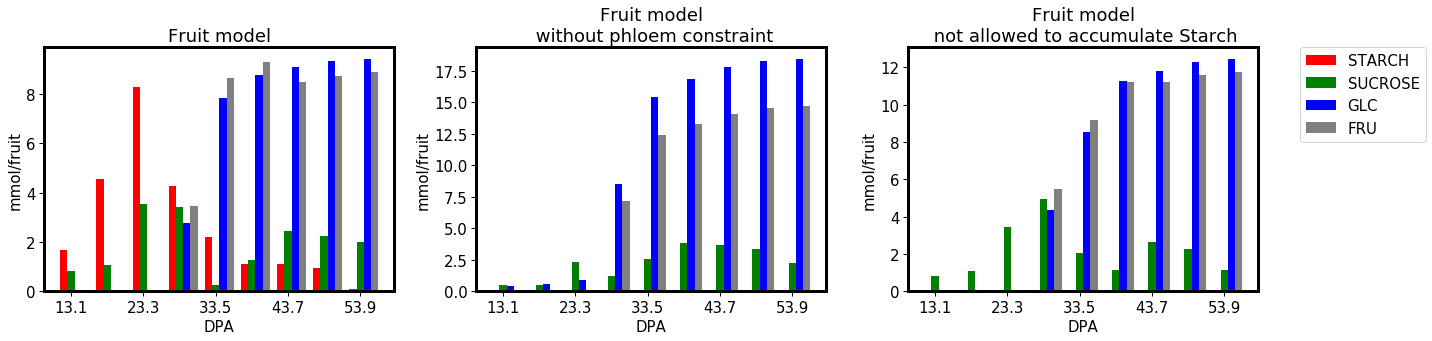

In [14]:


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,5))


ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
templist = list()
templistB = list()
templist2 = list()
templist2B = list()
templist3 = list()
templist3B = list()
templistC = list()
templistD = list()
templist2C = list()
templist2D = list()
templist3C = list()
templist3D = list()
xlist = list()
xlist2 = list()
xlist3 = list()
xlist4 = list()
xlist5 = list()
error_min = list()
error_max = list()
error_minB = list()
error_maxB = list()
error_min2 = list()
error_max2 = list()
error_min2B = list()
error_max2B = list()
error_min3 = list()
error_max3 = list()
error_min3B = list()
error_max3B = list()
error_minC = list()
error_maxC = list()
error_minD = list()
error_maxD = list()
error_min2C = list()
error_max2C = list()
error_min2D = list()
error_max2D = list()
error_min3C = list()
error_max3C = list()
error_min3D = list()
error_max3D = list()
for i in range(1,10):
    xlist.append(i*10)
    xlist2.append(i*10+2)
    xlist3.append(i*10+4)
    xlist4.append(i*10+6)
    templist.append(cobra_model6.solution.fluxes["STARCH_p_Transfer"+str(i)+str(i+1)])
    templistB.append(cobra_model6.solution.fluxes["SUCROSE_v_Transfer"+str(i)+str(i+1)]+solution2.fluxes["SUCROSE_c_Transfer"+str(i)+str(i+1)])
    templistC.append(cobra_model6.solution.fluxes["GLC_v_Transfer"+str(i)+str(i+1)]+solution2.fluxes["GLC_c_Transfer"+str(i)+str(i+1)])
    templistD.append(cobra_model6.solution.fluxes["FRU_v_Transfer"+str(i)+str(i+1)]+solution2.fluxes["FRU_c_Transfer"+str(i)+str(i+1)])
    templist2.append(cobra_model7.solution.fluxes["STARCH_p_Transfer"+str(i)+str(i+1)])
    templist2B.append(cobra_model7.solution.fluxes["SUCROSE_v_Transfer"+str(i)+str(i+1)]+temp_solution.fluxes["SUCROSE_c_Transfer"+str(i)+str(i+1)])
    templist2C.append(cobra_model7.solution.fluxes["GLC_v_Transfer"+str(i)+str(i+1)]+temp_solution.fluxes["GLC_v_Transfer"+str(i)+str(i+1)])
    templist2D.append(cobra_model7.solution.fluxes["FRU_v_Transfer"+str(i)+str(i+1)]+temp_solution.fluxes["FRU_v_Transfer"+str(i)+str(i+1)])
    templist3.append(cobra_model8.solution.fluxes["STARCH_p_Transfer"+str(i)+str(i+1)])
    templist3B.append(cobra_model8.solution.fluxes["SUCROSE_v_Transfer"+str(i)+str(i+1)]+temp_solution2.fluxes["SUCROSE_c_Transfer"+str(i)+str(i+1)])
    templist3C.append(cobra_model8.solution.fluxes["GLC_v_Transfer"+str(i)+str(i+1)]+temp_solution2.fluxes["GLC_v_Transfer"+str(i)+str(i+1)])
    templist3D.append(cobra_model8.solution.fluxes["FRU_v_Transfer"+str(i)+str(i+1)]+temp_solution2.fluxes["FRU_v_Transfer"+str(i)+str(i+1)])
    error_max.append(cobra_model6.fva.get("maximum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_min.append(cobra_model6.fva.get("minimum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_max2.append(cobra_model7.fva.get("maximum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_min2.append(cobra_model7.fva.get("minimum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_max3.append(cobra_model8.fva.get("maximum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_min3.append(cobra_model8.fva.get("minimum").get("STARCH_p_Transfer"+str(i)+str(i+1)))
    error_maxB.append(cobra_model6.fva.get("maximum").get("SUCROSE_signal"+str(i)))
    error_minB.append(cobra_model6.fva.get("minimum").get("SUCROSE_signal"+str(i)))
    error_max2B.append(cobra_model7.fva.get("maximum").get("SUCROSE_signal"+str(i)))
    error_min2B.append(cobra_model7.fva.get("minimum").get("SUCROSE_signal"+str(i)))
    error_max3B.append(cobra_model8.fva.get("maximum").get("SUCROSE_signal"+str(i)))
    error_min3B.append(cobra_model8.fva.get("minimum").get("SUCROSE_signal"+str(i)))
    error_maxC.append(cobra_model6.fva.get("maximum").get("GLC_signal"+str(i)))
    error_minC.append(cobra_model6.fva.get("minimum").get("GLC_signal"+str(i)))
    error_max2C.append(cobra_model7.fva.get("maximum").get("GLC_signal"+str(i)))
    error_min2C.append(cobra_model7.fva.get("minimum").get("GLC_signal"+str(i)))
    error_max3C.append(cobra_model8.fva.get("maximum").get("GLC_signal"+str(i)))
    error_min3C.append(cobra_model8.fva.get("minimum").get("GLC_signal"+str(i)))
    error_maxD.append(cobra_model6.fva.get("maximum").get("FRU_signal"+str(i)))
    error_minD.append(cobra_model6.fva.get("minimum").get("FRU_signal"+str(i)))
    error_max2D.append(cobra_model7.fva.get("maximum").get("FRU_signal"+str(i)))
    error_min2D.append(cobra_model7.fva.get("minimum").get("FRU_signal"+str(i)))
    error_max3D.append(cobra_model8.fva.get("maximum").get("FRU_signal"+str(i)))
    error_min3D.append(cobra_model8.fva.get("minimum").get("FRU_signal"+str(i)))

    ax1.bar(xlist,templist,width=2,color="red",zorder=-1,label="STARCH")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax1.bar(xlist2,templistB,width=2,color="green",zorder=-1,label="SUCROSE")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist2:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax1.bar(xlist3,templistC,width=2,color="blue",zorder=-1,label="GLC")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist3:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax1.bar(xlist4,templistD,width=2,color="grey",zorder=-1,label="FRU")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist4:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax2.bar(xlist,templist2,width=2,color="red",zorder=-1,label="STARCH")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax2.bar(xlist2,templist2B,width=2,color="green",zorder=-1,label="SUCROSE")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist2:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax2.bar(xlist3,templist2C,width=2,color="blue",zorder=-1,label="GLC")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist3:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax2.bar(xlist4,templist2D,width=2,color="grey",zorder=-1,label="FRU")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist4:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax3.bar(xlist,templist3,width=2,color="red",zorder=-1,label="STARCH")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax3.bar(xlist2,templist3B,width=2,color="green",zorder=-1,label="SUCROSE")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist2:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax3.bar(xlist3,templist3C,width=2,color="blue",zorder=-1,label="GLC")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist3:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax3.bar(xlist4,templist3D,width=2,color="grey",zorder=-1,label="FRU")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist4:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax1.set_title("Fruit model")

ax2.set_title("Fruit model\n without phloem constraint")

ax3.set_title("Fruit model\n not allowed to accumulate Starch")



plt.legend(bbox_to_anchor=(1.5, 1.03),fontsize=15)
for i in range(0,3):
    axes[i].set_xticks([xlist2[0],xlist2[2],xlist2[4],xlist2[6],xlist2[8]])
    axes[i].set_xticklabels([DPA[1],DPA[3],DPA[5],DPA[7],DPA[9]])
    axes[i].set_xlabel("DPA")
    axes[i].set_ylabel("mmol/fruit")
plt.tight_layout()
plt.show()

### Compare Phloem uptake rate

In [15]:


rxnlist= list()
for i in range(1,11):
    for met in ["Phloem_uptake_tx","CO2_tx"]:
        rxnlist.append(cobra_model2.reactions.get_by_id(met+str(i)))

cobra_model3 = cobra_model2.copy()

for i in range(1,11):
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000

temp_solution = pfba_Weighted(cobra_model3,weightings)        
        

rxnlist2= list()
for i in range(1,11):
    for met in ["Phloem_uptake_tx","CO2_tx"]:
        rxnlist2.append(cobra_model3.reactions.get_by_id(met+str(i)))
    
import time
print(time.ctime())
cobra_model6 = FBA_FVA_run(cobra_model2,cobra_model2.reactions.get_by_id("Final_Biomass_tx"),
                           rxnlist = rxnlist,
                           weightings=weightings)
cobra_model7 = FBA_FVA_run(cobra_model3,cobra_model3.reactions.get_by_id("Final_Biomass_tx"),
                           rxnlist = rxnlist2,
                           weightings=weightings)
print(time.ctime())

Wed Aug 14 15:50:07 2019
Runing pFBA
Setting SOF model
1.1026173081545578
Running FVA
Processing results
Runing pFBA
Setting SOF model
1.1026173081545576
Running FVA
Processing results
Wed Aug 14 15:52:18 2019


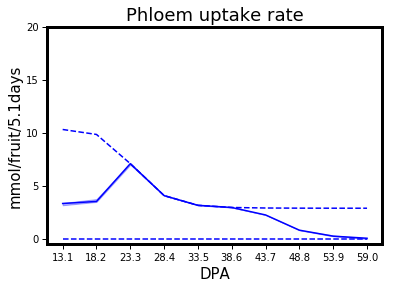

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

templist = list()
templist2 = list()
templist3 = list()
xlist = list()
error_min = list()
error_max = list()
error_min2 = list()
error_max2 = list()
upper_limit = list()
for i in range(1,11):
    xlist.append(i)
    upper_limit.append(cobra_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound)
    templist.append(solution2.fluxes["Phloem_uptake_tx"+str(i)])
    templist2.append(temp_solution.fluxes["Phloem_uptake_tx"+str(i)])
    error_max.append(abs(cobra_model6.fva.get("maximum").get("Phloem_uptake_tx"+str(i))))
    error_min.append(abs(cobra_model6.fva.get("minimum").get("Phloem_uptake_tx"+str(i))))
    error_max2.append(abs(cobra_model7.fva.get("maximum").get("Phloem_uptake_tx"+str(i))))
    error_min2.append(abs(cobra_model7.fva.get("minimum").get("Phloem_uptake_tx"+str(i))))
plt.plot(xlist,templist,"-",color="blue",label="phloem uptake when constrained")
plt.plot(xlist,upper_limit,"--",color="blue")
plt.plot(xlist,[0]*len(xlist),"--",color="blue",label="phloem uptake constraint")
plt.fill_between(xlist,error_max,error_min,alpha=0.3,color="blue")

plt.title("Phloem uptake rate")
plt.ylim(-0.5,20)
plt.yticks(fontsize=10)
plt.xticks(xlist,DPA[1:],fontsize=10)
plt.xlabel("DPA")
plt.ylabel("mmol/fruit/5.1days")
plt.show()


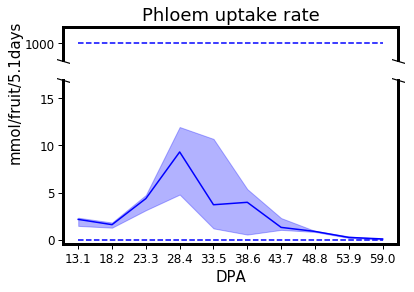

In [17]:
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

fig=plt.subplots(sharex=True)
gs = gridspec.GridSpec(2,1,height_ratios=[1,5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

templist = list()
templist2 = list()
templist3 = list()
xlist = list()
error_min = list()
error_max = list()
error_min2 = list()
error_max2 = list()
upper_limit = list()
for i in range(1,11):
    xlist.append(i)
    upper_limit.append(cobra_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound)
    templist.append(solution2.fluxes["Phloem_uptake_tx"+str(i)])
    templist2.append(temp_solution.fluxes["Phloem_uptake_tx"+str(i)])
    error_max.append(abs(cobra_model6.fva.get("maximum").get("Phloem_uptake_tx"+str(i))))
    error_min.append(abs(cobra_model6.fva.get("minimum").get("Phloem_uptake_tx"+str(i))))
    error_max2.append(abs(cobra_model7.fva.get("maximum").get("Phloem_uptake_tx"+str(i))))
    error_min2.append(abs(cobra_model7.fva.get("minimum").get("Phloem_uptake_tx"+str(i))))
    
ax1.plot(xlist,templist2,"-",label="Phloem uptake when unconstrained",color="blue")
ax1.fill_between(xlist,error_max2,error_min2,alpha=0.3,color="blue")
ax0.plot(xlist,[1000]*len(xlist),"--",color="blue")
ax1.plot(xlist,[0]*len(xlist),"--",color="blue",label="phloem uptake constraint")


ax0.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax0.tick_params(bottom=False,labelbottom=False)
ax1.tick_params(top=False)
ax0.set_ylim(990,1010)
ax0.set_yticks([1000])
ax1.set_ylim(-0.5,17)


ax0.set_title("Phloem uptake rate")
#plt.ylim(-0.5,4.5)
#plt.yticks(fontsize=10)
plt.xticks(xlist,DPA[1:],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("DPA")
plt.text(-1.1,22,"mmol/fruit/5.1days",rotation=90)
plt.text(0.4,16,"/",rotation=90)
plt.text(10.3,16,"/",rotation=90)
plt.text(0.4,18,"/",rotation=90)
plt.text(10.3,18,"/",rotation=90)
ax0.tick_params(axis='both', which='major', labelsize=12)
plt.show()
